In [84]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from os.path import join as oj
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
results_dir = '/accounts/projects/vision/chandan/class-weight-uncertainty/results/pmlb'
os.makedirs(results_dir, exist_ok=True)

rs = []
for name in ['logistic', 'mlp2', 'gb']:
    out_dir = '/scratch/users/vision/chandan/pacmed/no_flips/' + name
    fnames = sorted([fname for fname in os.listdir(out_dir)])
    results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), 
                                            "rb"))) for fname in tqdm(fnames)]
    rs.append(pd.concat(results_list, axis=1).T.infer_objects())

100%|██████████| 94/94 [00:00<00:00, 331.18it/s]


**note - cw is class-weight an pe is predictive-entropy**

# look at best dsets

In [86]:
for i in range(len(rs)):
    r = deepcopy(rs[i])
    r['auc_auc_diff'] = r.cw_auc_auc_test - r.pe_auc_auc_test
    r['calibration_diff'] = r.cw_calibration_rmse_test - r.pe_calibration_rmse_test
    rs[i] = r.sort_values(by='auc_auc_diff', ascending=False)

In [87]:
for r in rs:
    print(r[['dset_name', 'auc_auc_diff']].head(n=15))

                                            dset_name  auc_auc_diff
35                                             clean2     19.818254
88                                            titanic      8.362686
33                                              churn      8.242169
44                                                dis      6.093028
66                                              monk1      3.632265
6                              Hill_Valley_with_noise      3.353327
64                                        mofn-3-7-10      3.323263
46                                             german      2.715752
8                                               adult      2.595456
69                                           mushroom      2.398852
89                                             tokyo1      1.884478
4   GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...      1.318530
43                                           diabetes      0.957064
30                                           bug

**pick best common dsets**

In [88]:
s0 = set(rs[0]['dset_name'][:15])
s1 = set(rs[1]['dset_name'][:15])
s2 = set(rs[2]['dset_name'][:15])

common_names = list(s0 & s1 & s2)
common_names += ['clean2', 'coil2000', 'Hill_Valley_with_noise', 
                 'hypothyroid', 'diabetes', 'agaricus-lepiota']
print('common_names', len(common_names), common_names)

common_names 10 ['dis', 'churn', 'tokyo1', 'german', 'clean2', 'coil2000', 'Hill_Valley_with_noise', 'hypothyroid', 'diabetes', 'agaricus-lepiota']


# print statements

In [89]:
for i in range(3):
    rs[i] = rs[i][rs[i].dset_name.isin(common_names)]

In [90]:
results = rs[0].merge(rs[1], how='outer', on='dset_name', 
                      suffixes=('', '_y'))
results = pd.merge(results, rs[2], how='outer', on='dset_name',
                   suffixes=('_x', '_z'))

In [91]:
# results.keys()

In [92]:
results.pe_auc_auc_test_x

0    76.181632
1    53.375482
2    42.871320
3    71.465215
4    48.399229
5    65.662951
6    58.796164
7    94.412386
8    57.660494
9    29.730631
Name: pe_auc_auc_test_x, dtype: float64

In [93]:
print('\\begin{tabular}{l c c c c c c}')
print('& \\multicolumn{2}{c}{Logistic Regression} &\t \\multicolumn{2}{c}{2-layer MLP} &\t \\multicolumn{2}{c}{Gradient Boosting}\\\\')
print('Dataset	&	Class-weight &	Baseline &	Class-weight &	Baseline &	Class-weight &	Baseline\\\\')
print('\hline')
vals = [] 
thresh = 8
bf = '\\textbf{'
for name in sorted(common_names):
    row = results[results.dset_name == name].iloc[0]
    name = row.dset_name.replace("_", " ").replace('-', ' ').lower()
    s = f'{name}\t&'
    if row.cw_auc_auc_test_x > row.pe_auc_auc_test_x + thresh:
        s += f'\t{bf}{row.cw_auc_auc_test_x:0.2f} }} \t&\t{row.pe_auc_auc_test_x:0.2f} \t&'
    else:
        s += f'\t{row.cw_auc_auc_test_x:0.2f}\t&\t{row.pe_auc_auc_test_x:0.2f} \t&'
        
    if row.cw_auc_auc_test_y > row.pe_auc_auc_test_y + thresh:
        s += f'\t{bf}{row.cw_auc_auc_test_y:0.2f} }} \t&\t{row.pe_auc_auc_test_y:0.2f} \t&'
    else:
        s += f'\t{row.cw_auc_auc_test_y:0.2f}\t&\t{row.pe_auc_auc_test_y:0.2f} \t&'
        
    if row.cw_auc_auc_test_z > row.pe_auc_auc_test_z + thresh:
        s += f'\t{bf}{row.cw_auc_auc_test_z:0.2f} }} \t&\t{row.pe_auc_auc_test_z:0.2f}\\\\'
    else:
        s += f'\t{row.cw_auc_auc_test_z:0.2f}\t&\t{row.pe_auc_auc_test_z:0.2f}\\\\'
    print(s)
s2 = f'\\hline \nMean \t&\t {np.mean(results.cw_auc_auc_test_x):0.2f} \t&\t {np.mean(results.pe_auc_auc_test_x):0.2f}'
s2 += f'\t&\t \\textbf{{ {np.mean(results.cw_auc_auc_test_y):0.2f} }} \t&\t {np.mean(results.pe_auc_auc_test_y):0.2f}'
s2 += f'\t&\t \\textbf{{ {np.mean(results.cw_auc_auc_test_z):0.2f} }} \t&\t {np.mean(results.pe_auc_auc_test_z):0.2f}'
print(s2)

# d = np.sqrt(results.shape[0])
# s3 = f'\\hline \nSEM \t&\t {np.std(results.cw_auc_auc_test_x)/d:0.2f} \t&\t {np.std(results.pe_auc_auc_test_x)/d:0.2f}'
# s3 += f'\t&\t \\textbf{{ {np.std(results.cw_auc_auc_test_y)/d:0.2f} }} \t&\t {np.std(results.pe_auc_auc_test_y)/d:0.2f}'
# s3 += f'\t&\t \\textbf{{ {np.std(results.cw_auc_auc_test_z)/d:0.2f} }} \t&\t {np.std(results.pe_auc_auc_test_z)/d:0.2f}'
# print(s3)

print('\end{tabular}')

\begin{tabular}{l c c c c c c}
& \multicolumn{2}{c}{Logistic Regression} &	 \multicolumn{2}{c}{2-layer MLP} &	 \multicolumn{2}{c}{Gradient Boosting}\\
Dataset	&	Class-weight &	Baseline &	Class-weight &	Baseline &	Class-weight &	Baseline\\
\hline
hill valley with noise	&	74.82	&	71.47 	&	\textbf{64.38 } 	&	54.16 	&	45.42	&	45.23\\
agaricus lepiota	&	94.42	&	94.41 	&	96.76	&	96.76 	&	\textbf{96.76 } 	&	67.70\\
churn	&	\textbf{61.62 } 	&	53.38 	&	\textbf{76.01 } 	&	65.20 	&	86.62	&	81.82\\
clean2	&	\textbf{96.00 } 	&	76.18 	&	\textbf{93.58 } 	&	36.00 	&	15.88	&	17.15\\
coil2000	&	57.36	&	57.66 	&	55.11	&	52.58 	&	\textbf{74.46 } 	&	64.32\\
diabetes	&	59.75	&	58.80 	&	51.60	&	49.57 	&	56.71	&	57.62\\
dis	&	48.96	&	42.87 	&	\textbf{70.42 } 	&	37.65 	&	\textbf{50.09 } 	&	41.88\\
german	&	51.11	&	48.40 	&	\textbf{50.61 } 	&	28.45 	&	59.98	&	52.50\\
hypothyroid	&	26.30	&	29.73 	&	52.97	&	57.60 	&	\textbf{61.79 } 	&	45.26\\
tokyo1	&	67.55	&	65.66 	&	68.39	&	65.65 	&	\textbf{71.87 } 	&	57.41\\
\

# look at curves

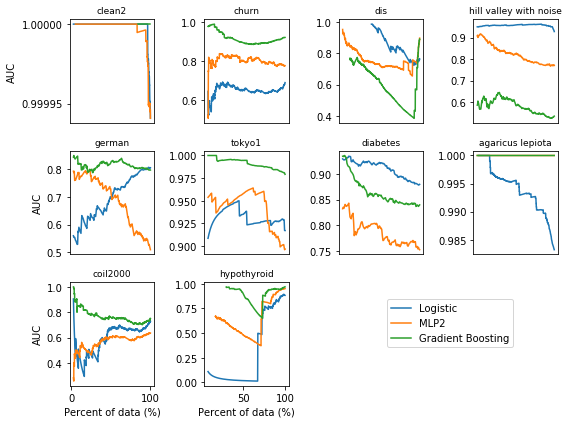

In [99]:

R, C = 3, 4
fig = plt.figure(figsize=(C * 2, R * 2))
for i in range(10):
    ax = plt.subplot(R, C, i + 1)
    row = results.iloc[i]
    plt.plot(row.cw_auc_percentages_test_x, row.cw_auc_performances_test_x, label='Logistic')
    plt.plot(row.cw_auc_percentages_test_y, row.cw_auc_performances_test_y, label='MLP2')
    plt.plot(row.cw_auc_percentages_test_z, row.cw_auc_performances_test_z, label='Gradient Boosting')
    
    if i == 0:
        
        ax.ticklabel_format(style='sci', useOffset=False)
        ax.set_yticks([0.99995, 1.0])
#         plt.yticks([0.9999, 1.0])
        
    if i % C == 0:
        plt.ylabel('AUC')
        
    plt.title(row.dset_name.replace('_', ' ').replace('-', ' ').lower(), fontsize=9)
    if i / C < R - 1:
        plt.xticks([])
    else:
        plt.xlabel('Percent of data (%)')
    
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.3))#loc='lower right')
# plt.legend()
# plt.subplots_adjust(hspace=0.3) #, wspace=0.1)
plt.savefig(oj(results_dir, 'fig_curves.pdf'))
plt.show()